In [1]:
import findspark
findspark.init('/home/zizhun/spark-3.1.1-bin-hadoop2.7')
# import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Taobao_cluster').getOrCreate()

In [2]:
df = spark.read.csv('UserBehavior.csv')
df = df.withColumnRenamed("_c0","user_id") \
        .withColumnRenamed("_c1","item_id") \
        .withColumnRenamed("_c2","category_id") \
        .withColumnRenamed("_c3","behavior") \
        .withColumnRenamed("_c4","timestamps")
df.printSchema()
df.columns
df.show(10)

root
 |-- user_id: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- behavior: string (nullable = true)
 |-- timestamps: string (nullable = true)

+-------+-------+-----------+--------+----------+
|user_id|item_id|category_id|behavior|timestamps|
+-------+-------+-----------+--------+----------+
|      1|2268318|    2520377|      pv|1511544070|
|      1|2333346|    2520771|      pv|1511561733|
|      1|2576651|     149192|      pv|1511572885|
|      1|3830808|    4181361|      pv|1511593493|
|      1|4365585|    2520377|      pv|1511596146|
|      1|4606018|    2735466|      pv|1511616481|
|      1| 230380|     411153|      pv|1511644942|
|      1|3827899|    2920476|      pv|1511713473|
|      1|3745169|    2891509|      pv|1511725471|
|      1|1531036|    2920476|      pv|1511733732|
+-------+-------+-----------+--------+----------+
only showing top 10 rows



In [3]:
from pyspark.sql.functions import from_unixtime

df = df.withColumn('datetime', from_unixtime(df.timestamps, format='yyyy-MM-dd HH:mm:ss').alias("datetime"))


In [ ]:
from pyspark.sql.functions import (dayofmonth, hour,
                                  dayofyear,month, dayofmonth,
                                  year,weekofyear,
                                  format_number, date_format, to_date, dayofweek)

df = df.withColumn('date', to_date(df.datetime)) \
        .withColumn('month', month(df.datetime)) \
        .withColumn('day', dayofmonth(df.datetime)) \
        .withColumn('hour', hour(df.datetime)) \
        .withColumn('dayofweek', dayofweek(df.datetime))
df.show()

In [4]:
df = df.where((df.datetime > '2017-11-23 00:00:00') & (df.datetime < '2017-12-04 23:59:59'))

In [5]:
df = df.limit(1000000)

In [ ]:
df_grouped = df.orderBy('user_id', 'item_id').groupBy('user_id', 'item_id')

In [ ]:
from pyspark.sql.functions import datediff, to_timestamp, max as sparkMax, min as sparkMin, sum as sparkSum, when

df_duration = df_grouped.agg((sparkMax(to_timestamp(df.datetime).cast("long")) - sparkMin(to_timestamp(df.datetime).cast("long"))).alias('duration'))

df_total_count = df_grouped.count().withColumnRenamed("count", "num_behaviors")

df_pv_count = df_grouped.agg(sparkSum(when(df.behavior == 'pv', 1).otherwise(0)).alias('pv_count'))
df_fav_count = df_grouped.agg(sparkSum(when(df.behavior == 'fav', 1).otherwise(0)).alias('fav_count'))
df_cart_count = df_grouped.agg(sparkSum(when(df.behavior == 'cart', 1).otherwise(0)).alias('cart_count'))
df_buy_count = df_grouped.agg(sparkSum(when(df.behavior == 'buy', 1).otherwise(0)).alias('buy_count'))

df_label = df_buy_count.withColumn('label', when(df_buy_count.buy_count > 0, 1).otherwise(0))
df_label = df_label.drop(df_label.buy_count)


In [7]:
df.createOrReplaceTempView("taobao")

In [ ]:
df.head()

In [8]:
df2 = spark.sql("""
SELECT 
    user_id,
    item_id,
    MAX(timestamps)-MIN(timestamps) as duration,
    COUNT(item_id) as behavior_count,
    SUM(CASE WHEN behavior = 'pv' THEN 1 ELSE 0 END) as pv,
    SUM(CASE WHEN behavior = 'fav' THEN 1 ELSE 0 END) as fav,
    SUM(CASE WHEN behavior = 'cart' THEN 1 ELSE 0 END) as cart,
    SUM(CASE WHEN behavior = 'buy' THEN 1 ELSE 0 END) as buy
FROM taobao
GROUP BY user_id, item_id
ORDER BY user_id, item_id ASC
""")
df2.show()

+-------+-------+--------+--------------+---+---+----+---+
|user_id|item_id|duration|behavior_count| pv|fav|cart|buy|
+-------+-------+--------+--------------+---+---+----+---+
|      1|1305059|     0.0|             1|  1|  0|   0|  0|
|      1|1323189|     0.0|             1|  1|  0|   0|  0|
|      1|1338525|     0.0|             1|  1|  0|   0|  0|
|      1|1340922|     0.0|             1|  1|  0|   0|  0|
|      1|1531036|     0.0|             1|  1|  0|   0|  0|
|      1|2028434|     0.0|             1|  1|  0|   0|  0|
|      1|2041056|     0.0|             1|  1|  0|   0|  0|
|      1|2087357| 29426.0|             2|  2|  0|   0|  0|
|      1|2104483|     0.0|             1|  1|  0|   0|  0|
|      1|2266567|     0.0|             1|  1|  0|   0|  0|
|      1|2268318|     0.0|             1|  1|  0|   0|  0|
|      1|2278603|     0.0|             1|  1|  0|   0|  0|
|      1|2286574|     0.0|             1|  1|  0|   0|  0|
|      1| 230380|     0.0|             1|  1|  0|   0|  

In [9]:
df2.createOrReplaceTempView("taobao_clustering")

df3 = spark.sql("""
SELECT 
    *,
    CASE WHEN buy > 0 THEN 1 ELSE 0 END as label
FROM taobao_clustering
""")

In [ ]:
df3.show()

In [ ]:
df_duration.show()
df_total_count.show()
df_pv_count.show()
df_fav_count.show()
df_cart_count.show()
df_buy_count.show()

In [ ]:
df1 = df_duration.join(df_total_count, on=['user_id', 'item_id']) \
.join(df_pv_count, on=['user_id', 'item_id']) \
.join(df_fav_count, on=['user_id', 'item_id']) \
.join(df_cart_count, on=['user_id', 'item_id']) \
.join(df_buy_count, on=['user_id', 'item_id']).join(df_label, on=['user_id', 'item_id'])



In [ ]:
# from pyspark.sql.functions import countDistinct
# df_label.select(countDistinct(df_label.label)).show()

In [10]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

In [ ]:
df1.columns

In [11]:
feat_cols = [
 'duration',
 'behavior_count',
 'pv',
 'fav',
 'cart',
 'buy',
    'label']

In [ ]:
df1.show(100)

In [ ]:
df4 = df3.limit(100000)

In [12]:
assembler = VectorAssembler(inputCols = feat_cols, outputCol = 'features')

In [ ]:
df1.head()

In [13]:
final_data = assembler.transform(df3)

In [ ]:
final_data.printSchema()

In [ ]:
final_data.show(5)

In [14]:
from pyspark.ml.feature import StandardScaler

In [15]:
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures')

In [16]:
scaler_model = scaler.fit(final_data)
cluster_final_data = scaler_model.transform(final_data)

In [ ]:
cluster_final_data.show(10)

### test standard scaler targetting single column and compare results with assembling

In [17]:
from pyspark.ml.clustering import KMeans

In [18]:
df4 = cluster_final_data.drop('user_id').drop('item_id').drop('duration').drop('behavior_count') \
                .drop('pv').drop('fav').drop('buy').drop('cart').drop('label').drop('features')

In [19]:
kmeans5 = KMeans(featuresCol = 'scaledFeatures', k = 5, seed=2)
model_k5 = kmeans5.fit(df4)

In [ ]:
# using scaledFeatures
# featureCol = 'scaledFeatures'
featureCol = 'features'

kmeans2 = KMeans(featuresCol = 'scaledFeatures', k = 2, seed=2)
kmeans3 = KMeans(featuresCol = 'scaledFeatures', k = 3, seed=2)
kmeans5 = KMeans(featuresCol = 'scaledFeatures', k = 5, seed=2)
kmeans4 = KMeans(featuresCol = 'scaledFeatures', k = 4, seed=2)
kmeans6 = KMeans(featuresCol = 'scaledFeatures', k = 6, seed=2)
kmeans7 = KMeans(featuresCol = 'scaledFeatures', k = 7, seed=2)


model_k2 = kmeans2.fit(cluster_final_data)
model_k3 = kmeans3.fit(cluster_final_data)
model_k4 = kmeans4.fit(cluster_final_data)
model_k5 = kmeans5.fit(cluster_final_data)
model_k6 = kmeans6.fit(cluster_final_data)
model_k7 = kmeans7.fit(cluster_final_data)


In [ ]:
summary = model_k5.summary
print(summary.k)
print(summary.clusterSizes)
print(summary.trainingCost)
print(summary.k)
print(summary.k)

### Elbow Method

In [ ]:
cost = [model_k2.summary.trainingCost,
       model_k3.summary.trainingCost,
       model_k4.summary.trainingCost,
       model_k5.summary.trainingCost,
       model_k6.summary.trainingCost,
       model_k7.summary.trainingCost,
       ]



In [ ]:
import matplotlib.pyplot as plt

fit = plt.figure(figsize=(5,5), dpi= 100)
plt.xlabel('number of clusters k')
plt.ylabel('cost')
plt.plot(range(2, 8), cost)
plt.show()

In [ ]:
df_k2 = model_k2.transform(cluster_final_data)
df_k3 = model_k3.transform(cluster_final_data)
df_k4 = model_k4.transform(cluster_final_data)
df_k5 = model_k5.transform(cluster_final_data)
df_k6 = model_k6.transform(cluster_final_data)
df_k7 = model_k7.transform(cluster_final_data)

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette2 = ClusteringEvaluator().evaluate(df_k2)
silhouette3 = ClusteringEvaluator().evaluate(df_k3)
silhouette4 = ClusteringEvaluator().evaluate(df_k4)
silhouette5 = ClusteringEvaluator().evaluate(df_k5)
silhouette6 = ClusteringEvaluator().evaluate(df_k6)
silhouette7 = ClusteringEvaluator().evaluate(df_k7)


In [ ]:
cost = [silhouette2,
       silhouette3,
       silhouette4,
       silhouette5,
       silhouette6,
       silhouette7
       ]

import matplotlib.pyplot as plt

fit = plt.figure(figsize=(5,5), dpi= 100)
plt.xlabel('number of clusters k')
plt.ylabel('cost')
plt.plot(range(2, 8), cost)
plt.show()

In [ ]:
model_k6.transform(cluster_final_data).show()

In [ ]:
df_k2 = model_k2.transform(cluster_final_data)
df_k3 = model_k3.transform(cluster_final_data)
df_k4 = model_k4.transform(cluster_final_data)
df_k5 = model_k5.transform(cluster_final_data)
df_k6 = model_k6.transform(cluster_final_data)
df_k7 = model_k7.transform(cluster_final_data)
df_k8 = model_k8.transform(cluster_final_data)
df_k9 = model_k9.transform(cluster_final_data)
df_k10 = model_k10.transform(cluster_final_data)



In [ ]:
df_k2.groupBy('prediction').count().show()
df_k3.groupBy('prediction').count().show()
df_k4.groupBy('prediction').count().show()
df_k5.groupBy('prediction').count().show()
df_k6.groupBy('prediction').count().show()
df_k7.groupBy('prediction').count().show()
df_k8.groupBy('prediction').count().show()
df_k9.groupBy('prediction').count().show()
df_k10.groupBy('prediction').count().show()

In [21]:
df_k5 = model_k5.transform(cluster_final_data)

In [25]:
df_k5.show()

+-------+-------+--------+--------------+---+---+----+---+-----+--------------------+--------------------+----------+
|user_id|item_id|duration|behavior_count| pv|fav|cart|buy|label|            features|      scaledFeatures|prediction|
+-------+-------+--------+--------------+---+---+----+---+-----+--------------------+--------------------+----------+
|      1|1305059|     0.0|             1|  1|  0|   0|  0|    0| (7,[1,2],[1.0,1.0])|(7,[1,2],[0.93053...|         0|
|      1|1323189|     0.0|             1|  1|  0|   0|  0|    0| (7,[1,2],[1.0,1.0])|(7,[1,2],[0.93053...|         0|
|      1|1338525|     0.0|             1|  1|  0|   0|  0|    0| (7,[1,2],[1.0,1.0])|(7,[1,2],[0.93053...|         0|
|      1|1340922|     0.0|             1|  1|  0|   0|  0|    0| (7,[1,2],[1.0,1.0])|(7,[1,2],[0.93053...|         0|
|      1|1531036|     0.0|             1|  1|  0|   0|  0|    0| (7,[1,2],[1.0,1.0])|(7,[1,2],[0.93053...|         0|
|      1|2028434|     0.0|             1|  1|  0|   0|  

In [26]:
df_k5.drop('user_id').drop('item_id').describe().show()

+-------+-----------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+
|summary|         duration|    behavior_count|                pv|                fav|               cart|                 buy|               label|        prediction|
+-------+-----------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+
|  count|           756408|            756408|            756408|             756408|             756408|              756408|              756408|            756408|
|   mean|21433.50689707142|1.3220378420111898| 1.184676788188385| 0.0371333989064103|0.07331228649088851|0.026915368425505813|0.025566889826654397|0.4321940011210881|
| stddev|85385.05928533341|1.0746465690895712|0.9953649718484974|0.19056521625685005| 0.2690200842701817| 0.17201339406933566| 0.15783933890990312|1.1010077907100033

In [22]:
df_k5.createOrReplaceTempView("purchase_clustered")

In [29]:
df_k5_statistics = spark.sql("""
SELECT prediction AS cluster,
        COUNT(DISTINCT user_id) AS user,
        COUNT(item_id) AS behavior,
        ROUND(AVG(duration)/3600,2) AS avg_duration,
        ROUND(AVG(behavior_count),2) as avg_num_behaviors,
        ROUND(AVG(pv),2) as avg_pv,
        ROUND(AVG(fav),2) as avg_fav,
        ROUND(AVG(cart),2) as avg_cart,
        ROUND(AVG(buy),2) as avg_buy,
        ROUND(AVG(label),2) as avg_label
FROM purchase_clustered
GROUP BY prediction
ORDER BY prediction asc
""")
df_k5_statistics.show()

+-------+----+--------+------------+-----------------+------+-------+--------+-------+---------+
|cluster|user|behavior|avg_duration|avg_num_behaviors|avg_pv|avg_fav|avg_cart|avg_buy|avg_label|
+-------+----+--------+------------+-----------------+------+-------+--------+-------+---------+
|      0|9701|  639437|        0.91|             1.12|  1.12|    0.0|     0.0|    0.0|      0.0|
|      1|6673|   19246|       29.08|             3.08|  1.76|   0.07|     0.2|   1.05|      1.0|
|      2|6688|   28996|       93.98|             3.97|   3.7|   0.05|    0.22|    0.0|      0.0|
|      3|3700|   25239|       10.52|             1.62|  0.58|   1.01|    0.03|    0.0|      0.0|
|      4|6853|   43490|        8.49|             1.61|  0.59|    0.0|    1.02|    0.0|      0.0|
+-------+----+--------+------------+-----------------+------+-------+--------+-------+---------+



In [30]:
import pandas as pd
df_k5_pandas = df_k5_statistics.toPandas()

In [31]:
print(df_k5_pandas)

   cluster  user  behavior  avg_duration  avg_num_behaviors  avg_pv  avg_fav  \
0        0  9701    639437          0.91               1.12    1.12     0.00   
1        1  6673     19246         29.08               3.08    1.76     0.07   
2        2  6688     28996         93.98               3.97    3.70     0.05   
3        3  3700     25239         10.52               1.62    0.58     1.01   
4        4  6853     43490          8.49               1.61    0.59     0.00   

   avg_cart  avg_buy  avg_label  
0      0.00     0.00        0.0  
1      0.20     1.05        1.0  
2      0.22     0.00        0.0  
3      0.03     0.00        0.0  
4      1.02     0.00        0.0  


In [38]:
df_k5 = df_k5_pandas.drop(columns = ['cluster'])
columns = df_k5.columns

In [51]:
print(df_k5)
print(columns)

   user  behavior  avg_duration  avg_num_behaviors  avg_pv  avg_fav  avg_cart  \
0  9701    639437          0.91               1.12    1.12     0.00      0.00   
1  6673     19246         29.08               3.08    1.76     0.07      0.20   
2  6688     28996         93.98               3.97    3.70     0.05      0.22   
3  3700     25239         10.52               1.62    0.58     1.01      0.03   
4  6853     43490          8.49               1.61    0.59     0.00      1.02   

   avg_buy  avg_label  
0     0.00        0.0  
1     1.05        1.0  
2     0.00        0.0  
3     0.00        0.0  
4     0.00        0.0  
Index(['user', 'behavior', 'avg_duration', 'avg_num_behaviors', 'avg_pv',
       'avg_fav', 'avg_cart', 'avg_buy', 'avg_label'],
      dtype='object')


In [80]:
import matplotlib.pyplot as plt
import numpy as np

def heatmap(mean_matrix, columns, n = 5):
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)
    fit = plt.figure(figsize=(10,10), dpi= 300)
    im = ax.imshow(mean_matrix)
    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(n))
    # ... and label them with the respective list entries
    ax.set_xticklabels(columns)
    _ = []
    for i in range(n):
        _.append('cluster'+str(i+1))
    ax.set_yticklabels(_)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    for i in range(n):
        for j in range(len(columns)):
            text = ax.text(j, i, mean_matrix[i, j],
                        ha="center", va="center", color="w")
    ax.set_title("Heatmap of the clustering on standardized scaled features")
    fig.tight_layout()
    plt.show()

In [81]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_k5)
print(np.around(scaler.transform(df_k5), 2))

[[ 1.57  2.   -0.81 -1.08 -0.37 -0.58 -0.79 -0.5  -0.5 ]
 [-0.03 -0.54  0.01  0.75  0.18 -0.4  -0.25  2.    2.  ]
 [-0.02 -0.5   1.92  1.58  1.86 -0.45 -0.2  -0.5  -0.5 ]
 [-1.59 -0.52 -0.53 -0.62 -0.84  2.   -0.71 -0.5  -0.5 ]
 [ 0.07 -0.44 -0.59 -0.63 -0.83 -0.58  1.94 -0.5  -0.5 ]]


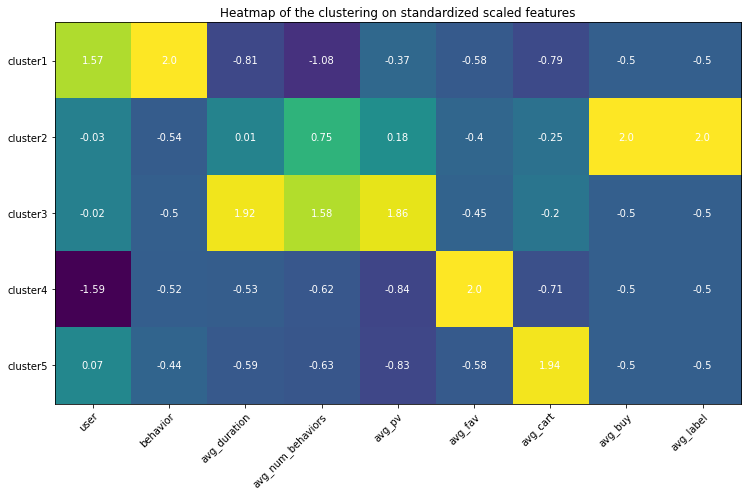

<Figure size 3000x3000 with 0 Axes>

In [82]:
heatmap(np.around(scaler.transform(df_k5), 2), columns, n = 5)

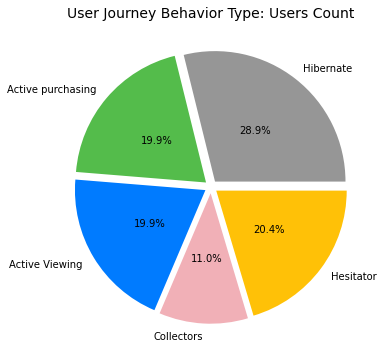

In [92]:
data = df_k5['user']

pie, ax = plt.subplots(figsize=[10,6])
labels = ['Hibernate','Active purchasing', 'Active Viewing', 'Collectors', 'Hesitator']
plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*5, labels=labels, pctdistance=0.5, colors = ['#969696','#54bc4b', '#007bff', '#f1b0b7', '#ffc107'])
plt.title("User Journey Behavior Type: Users Count", fontsize=14);

In [57]:
print(df_k5)

   user  behavior  avg_duration  avg_num_behaviors  avg_pv  avg_fav  avg_cart  \
0  9701    639437          0.91               1.12    1.12     0.00      0.00   
1  6673     19246         29.08               3.08    1.76     0.07      0.20   
2  6688     28996         93.98               3.97    3.70     0.05      0.22   
3  3700     25239         10.52               1.62    0.58     1.01      0.03   
4  6853     43490          8.49               1.61    0.59     0.00      1.02   

   avg_buy  avg_label  
0     0.00        0.0  
1     1.05        1.0  
2     0.00        0.0  
3     0.00        0.0  
4     0.00        0.0  


In [35]:
print(df_k5_pandas['cluster'])

0    0
1    1
2    2
3    3
4    4
Name: cluster, dtype: int32


In [39]:
print(columns)

Index(['user', 'behavior', 'avg_duration', 'avg_num_behaviors', 'avg_pv',
       'avg_fav', 'avg_cart', 'avg_buy', 'avg_label'],
      dtype='object')
